In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from childes_mi.utils.paths import PHONBANK_DFS, DATA_DIR
from childes_mi.utils.general import flatten

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
phone_df = pd.read_pickle(PHONBANK_DFS/'phone_df.pickle')

In [5]:
phone_df['n_phones'] = [len(list(flatten(i))) for i in phone_df.phones.values]

In [6]:
phone_df[:3]

,name,transcript_id,age,dataset,language,sex,phones,orthography,xml_loc,n_phones
0,0,020926,2.833,Providence,eng,male,"[[ˈhi, ˈhæ, rəs], [ˈhi, ˈhæ, rəs], [ˈkævəʔ, ˈp...","[[[can, I], have, this], [[can, I], have, this...",/mnt/cube/tsainbur/Projects/github_repos/child...,1772
0,0,030006,3.000,Providence,eng,male,"[[*, haʊ, ˈbaʊ, *, ɪ, ˈdeɪ, mætʃ], [deɪ, ˈmætʃ...","[[xxx, how, <a>bout, xxx, if, they, match], [t...",/mnt/cube/tsainbur/Projects/github_repos/child...,2277
0,0,011117,2.000,Providence,eng,male,"[[None], [None], [None], [hɪ, ˈmi], [ˈbu], [No...","[[xxx], [xxx], [xxx], [help, me], [bowl], [xxx...",/mnt/cube/tsainbur/Projects/github_repos/child...,561


In [7]:
phone_df.dataset.unique()

array(['Providence', 'Davis', 'Goad'], dtype=object)

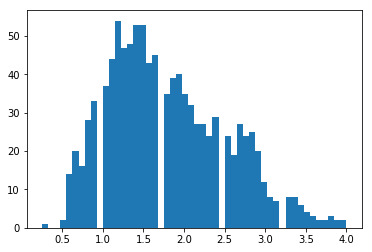

In [8]:
plt.hist(phone_df.age.values, bins = 50);

In [9]:
print("There are {} phones in this dataset".format(np.sum(phone_df.n_phones)))

There are 618583 phones in this dataset


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


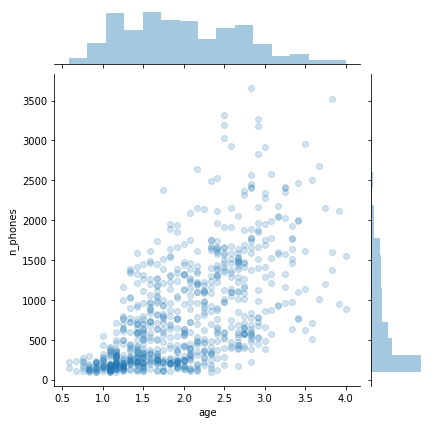

In [10]:
import seaborn as sns
sns.jointplot("age", "n_phones", data=phone_df[phone_df.n_phones > 100], alpha=0.2)

In [11]:
np.median(phone_df.n_phones)

306.0

## MI
- for each sequence, calculate the decay of a sequence as a function of distance between elements for that sequence indiividually
- Treat each phoneme as unique for that child, and compute MI across children

In [12]:
from childes_mi.information_theory import mutual_information as mi

In [13]:
distances = np.arange(1,101)

#### Run MI by age cohort

In [14]:
phone_df[:3]

,name,transcript_id,age,dataset,language,sex,phones,orthography,xml_loc,n_phones
0,0,020926,2.833,Providence,eng,male,"[[ˈhi, ˈhæ, rəs], [ˈhi, ˈhæ, rəs], [ˈkævəʔ, ˈp...","[[[can, I], have, this], [[can, I], have, this...",/mnt/cube/tsainbur/Projects/github_repos/child...,1772
0,0,030006,3.000,Providence,eng,male,"[[*, haʊ, ˈbaʊ, *, ɪ, ˈdeɪ, mætʃ], [deɪ, ˈmætʃ...","[[xxx, how, <a>bout, xxx, if, they, match], [t...",/mnt/cube/tsainbur/Projects/github_repos/child...,2277
0,0,011117,2.000,Providence,eng,male,"[[None], [None], [None], [hɪ, ˈmi], [ˈbu], [No...","[[xxx], [xxx], [xxx], [help, me], [bowl], [xxx...",/mnt/cube/tsainbur/Projects/github_repos/child...,561


In [15]:
age_cohorts = [[0.5, 1], [1, 1.5], [1.5, 2], [2, 2.5], [2.5, 3], [3, 20]]

In [16]:
def concat(arr):
    """ingore concatenation of zero length list"""
    if len(arr) ==0:
        return []
    else:
        return np.concatenate(arr)

In [26]:
mi_df = pd.DataFrame(
    columns=[
        "MI",
        "MI_var",
        "shuff_MI",
        "shuff_MI_var",
        "distances",
        "age_cohort_low",
        "age_cohort_high",
        "n_phones",
        "n_unique_phones",
        'shuffling'
    ]
)
    # for each age cohort
for (age_cohort_low, age_cohort_high) in tqdm(age_cohorts):
    cohort_subset = phone_df[
        (phone_df.age > age_cohort_low) & (phone_df.age <= age_cohort_high)
    ]
    ### make list of phones
    cohort_phones_list = [
        [
          i for i in "".join(flatten([i for i in flatten(row.phones) if i is not None]))
        ]
        for transcript_i, (idx, row) in enumerate(cohort_subset.iterrows())
    ]
    print('phones list:', [' '.join(i) for i in cohort_phones_list][0][:100])

    ### make list of phones shuffled within words
    cohort_phones_list_shuffled_within_words = [
            list(concat([np.random.permutation(list(i)) for i in flatten(row.phones) if i is not None]))
            for transcript_i, (idx, row) in enumerate(cohort_subset.iterrows())
    ]
    print('phones list (shuffled within word):', [' '.join(i) for i in cohort_phones_list_shuffled_within_words][0][:100])

    ### make list of phones shuffled between words
    cohort_phones_list_shuffled_between_words = [
            list(''.join(list(np.random.permutation([i for i in flatten(row.phones) if i is not None]))))
            for transcript_i, (idx, row) in enumerate(cohort_subset.iterrows())
    ]
    print('phones list (shuffled between word):', [' '.join(i) for i in cohort_phones_list_shuffled_between_words][0][:100])

    cohort_phones_list_shuffled_within_sentence = [list(np.concatenate([np.random.permutation(list(''.join(list(flatten([i for i in sent if i is not None]))))) for sent in  trans]))
     for trans in cohort_subset.phones.values]
    print('phones list (shuffled within sentences):', [' '.join(i) for i in cohort_phones_list_shuffled_within_sentence][0][:100])

    # get number of unique elements
    n_phones = len(np.concatenate(cohort_phones_list))
    n_unique_phones = 0 #len(np.unique(np.concatenate(cohort_phones)))
    
    # make each phone symbol specific to the transcript
    #for transcript_i, (idx, row) in enumerate(cohort_subset.iterrows()):
    #    cohort_phones_list[transcript_i] = [str(transcript_i) + i for i in cohort_phones_list[transcript_i]]
    #    cohort_phones_list_shuffled_between_words[transcript_i] = [str(transcript_i) + i for i in cohort_phones_list_shuffled_between_words[transcript_i]]
    #    cohort_phones_list_shuffled_between_words[transcript_i] = [str(transcript_i) + i for i in cohort_phones_list_shuffled_between_words[transcript_i]]
    #    cohort_phones_list_shuffled_within_sentence[transcript_i] = [str(transcript_i) + i for i in cohort_phones_list_shuffled_within_sentence[transcript_i]]

    (MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
        cohort_phones_list, distances=distances, n_jobs=-1
    )
    mi_df.loc[len(mi_df)] = [
        MI,
        MI_var,
        shuff_MI,
        shuff_MI_var,
        distances,
        age_cohort_low,
        age_cohort_high,
        n_phones,
        n_unique_phones,
        'full'
    ]
    
    (MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
        cohort_phones_list_shuffled_within_words, distances=distances, n_jobs=-1
    )
    mi_df.loc[len(mi_df)] = [
        MI,
        MI_var,
        shuff_MI,
        shuff_MI_var,
        distances,
        age_cohort_low,
        age_cohort_high,
        n_phones,
        n_unique_phones,
        'shuffled_within_words'
    ]
    
    (MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
        cohort_phones_list_shuffled_between_words, distances=distances, n_jobs=-1
    )
    mi_df.loc[len(mi_df)] = [
        MI,
        MI_var,
        shuff_MI,
        shuff_MI_var,
        distances,
        age_cohort_low,
        age_cohort_high,
        n_phones,
        n_unique_phones,
        'shuffled_between_words'
    ]
    
    (MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
        cohort_phones_list_shuffled_within_sentence, distances=distances, n_jobs=-1
    )
    mi_df.loc[len(mi_df)] = [
        MI,
        MI_var,
        shuff_MI,
        shuff_MI_var,
        distances,
        age_cohort_low,
        age_cohort_high,
        n_phones,
        n_unique_phones,
        'shuffled_within_sentence'
    ]

phones list: ˈ n a ɪ ʌ ˈ j ɪ ɪ m ˈ b ʌ ə m ˈ b ʌ ˈ d ɛ ˈ ɑ ˈ b ɛ ˈ m i ˈ b ɪ ˈ ʌ ɛ ˈ t a ɪ ˈ ɡ ɪ ˈ ɡ a ɪ ˈ d ʌ ˈ 
phones list (shuffled within word): a ˈ n ɪ ɪ j ʌ ˈ ʌ b ˈ m ɪ ə ˈ m ʌ b d ɛ ˈ ˈ ɑ ˈ ɛ b m i ˈ b ˈ ɪ ʌ ˈ ɪ t a ɛ ˈ ˈ ɡ ɪ a ɡ ˈ ɪ d ˈ ʌ m 
phones list (shuffled between word): ˈ d æ ˈ ɛ ˈ h ɛ ˈ m i ˈ ɡ ɪ ˈ ʌ ˈ ɛ ˈ h ɛ ɛ ˈ b w o ˈ d ɛ ˈ æ ə ˈ b u ˈ o ˈ k æ ˈ d ɛ ˈ b ʊ k t ˈ e 
phones list (shuffled within sentences): ɪ ˈ a n ˈ j ɪ ʌ b ɪ ˈ m ʌ ˈ ə m b ʌ ˈ ɛ d ɑ ˈ ˈ ɛ b i ˈ m b ɪ ˈ ʌ ˈ ˈ a t ɪ ɛ ˈ ɡ ɪ ˈ ɡ a ɪ d ˈ ʌ ˈ 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    1.1s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    1.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    1.7s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    1.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    1.0s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    1.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    1.7s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    1.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.9s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    1.0s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    1.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    1.7s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    1.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    1.0s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    1.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    1.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    1.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.9s finished


phones list: ˈ a ʊ ˈ u ˈ i ˈ ɑ ˈ ɔ ˈ e ɪ ð i ˈ ð a ʊ ˈ ɪ z ˈ æ j ˈ ɪ ˈ ʌ ɔ ˈ ɔ ː ʔ ə ˈ ɔ ː ʔ ə ˈ o ˈ i ː ˈ i ː ˈ 
phones list (shuffled within word): ʊ a ˈ ˈ u ˈ i ɑ ˈ ɔ ˈ ð ˈ ɪ e i ð ʊ a ˈ z ɪ ˈ æ j ˈ ɪ ˈ ˈ ʌ ɔ ə ʔ ɔ ː ˈ ː ɔ ʔ ˈ ə ˈ o ː ˈ i ː i ˈ ˈ 
phones list (shuffled between word): ˈ l u ː ˈ ɔ ː ʔ ə ə ˈ d i ə ˈ d ɛ ð ˈ b ɑ p ˈ b u ə u ˈ b æ ː ʔ ɡ ə ˈ n æ n ə ˈ z ɪ ə ˈ n e ɪ ̃ n ɛ 
phones list (shuffled within sentences): ʊ a ˈ ˈ u ˈ ˈ ɔ ɑ i ˈ ð ɪ ʊ i ˈ e a ð ˈ j ˈ æ z ɪ ˈ ɪ ˈ ɔ ʌ ˈ ə ː ˈ ɔ ʔ ɔ ː ʔ ˈ ə o ˈ ː ˈ i ˈ ː i ˈ 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    1.6s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    2.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    3.3s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    3.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.4s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    1.5s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    2.1s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.3s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    3.2s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    3.2s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    1.5s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    2.1s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.3s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    3.3s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    3.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.4s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    1.5s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    2.1s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    3.3s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    3.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.4s finished


phones list: h ɪ ˈ m i ˈ b u ə ˈ h ɪ t s ɪ * ʊ ˈ h ʌ ə ˈ b u * ˈ h e ɪ ː ˈ ʌ t ˈ m ɑ m i ɪ ˈ s i ɾ w ə ˈ s æ ʔ ˈ 
phones list (shuffled within word): h ɪ ˈ i m u b ˈ ə s ˈ t h ɪ ɪ * ʊ ˈ ʌ h ə b u ˈ * h ˈ ɪ e ː t ʌ ˈ ɑ i ˈ m m ɪ ɾ s ˈ i ʔ ə s w æ ˈ ʌ 
phones list (shuffled between word): ˈ m ɑ m i ə ˈ m ̩ ˈ j i j i w ə d i ˈ j e ɪ ˈ ʔ w ʌ n ʔ w ə ˈ s æ * ˈ t æ ˈ w a ɪ ˈ s æ ˈ w ʌ n ˈ w 
phones list (shuffled within sentences): ɪ i m h ˈ u b ˈ ʌ ˈ ʊ ˈ * ɪ ɪ h ə s t h ə b ˈ u h ː e * ˈ ɪ t ʌ ˈ ˈ m ɑ i m s ɾ i ɪ ˈ w ə ˈ s ʔ æ e 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    1.7s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    2.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    3.7s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    3.7s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.8s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    1.6s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    2.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    3.8s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    3.8s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.9s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    1.5s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    2.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    3.8s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    3.8s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.9s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    1.5s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    2.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    3.6s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    3.6s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.8s finished


phones list: ˈ ɛ z ɑ ˈ b o k * ˈ m ɑ m i e ɪ ˈ w ɪ m ˈ ɛ ː ˈ m ɑ m i ˈ ɛ ˈ m ɑ m i ˈ ɛ ˈ m ɑ m i ˈ ɛ ˈ m ɑ m i ˈ 
phones list (shuffled within word): ɛ ˈ z b k ɑ o ˈ * ˈ ɑ i m m w ɪ m ɪ ˈ e ɛ ˈ ː i ɑ ˈ m m ˈ ɛ i ɑ m m ˈ ˈ ɛ m ˈ i m ɑ ɛ ˈ m ˈ m i ɑ ʌ 
phones list (shuffled between word): ˈ n a ɪ ˈ ð ɪ z i ˈ ʌ ˈ w ɪ ˈ ʌ ʔ ˈ d i ˈ m ̩ ʌ ˈ d ɪ ˈ t i ˈ m ɑ m i ˈ w ʌ ː n ˈ w i ˈ ʌ ˈ o ˈ b ɔ 
phones list (shuffled within sentences): o b z ˈ ɑ ˈ ɛ k ɪ m i ɑ ˈ * m ɪ w m ˈ e ˈ i ˈ ɛ ː m ɑ m ˈ ɛ m ɑ ˈ m i ˈ ɑ m ˈ ɑ m i ɛ ɛ i ˈ ˈ m m m 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    1.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    2.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.7s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    3.9s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    3.9s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.0s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    1.7s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    2.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    4.0s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    4.0s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.2s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    1.7s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    2.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    3.9s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    3.9s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.0s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    1.7s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    2.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    4.0s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    4.0s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.1s finished


phones list: ˈ h i ˈ h æ r ə s ˈ h i ˈ h æ r ə s ˈ k æ v ə ʔ ˈ p l i s ˈ ʊ p s ˈ n o ˈ w a ɪ f ˈ n ʌ ˈ n ʌ ˈ n o 
phones list (shuffled within word): ˈ h i æ h ˈ s ə r h i ˈ h ˈ æ s ə r ʔ k ˈ v æ ə s p ˈ l i s ˈ p ʊ n o ˈ f a w ˈ ɪ ʌ n ˈ ˈ ʌ n o n ˈ 
phones list (shuffled between word): ˈ n i ɾ ɛ ˈ ð ɪ ɡ ɛ ˈ h ʌ ˈ b o ˈ s u ː z ˈ l æ ɾ ə ˈ d ɛ ː ˈ ɪ n ə ˈ m a ɪ t o ˈ t ʃ u ˈ e ɪ k ʰ ˈ 
phones list (shuffled within sentences): i s ˈ æ h ˈ r h ə ˈ r æ h ə s i h ˈ ə æ v ʔ ˈ s p ˈ l k i s p ʊ ˈ n o ˈ w ɪ a ˈ f ʌ n n n ˈ ʌ ˈ ˈ o 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    1.7s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    2.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    3.8s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    3.8s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.0s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    1.6s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    2.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    3.8s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    3.8s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.0s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    1.7s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    2.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    3.8s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    3.8s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.0s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    1.6s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    2.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    3.9s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    3.9s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.1s finished


phones list: ˈ j ɛ s ˈ p l i z ˈ l ʊ k ˈ h a ɪ ˈ d ʒ i ˈ d ʒ i ˈ w ʌ ˈ d o i ˈ w ɛ z ˈ s t ɛ l ə z ˈ ɡ ɪ n * ˈ s 
phones list (shuffled within word): ɛ s j ˈ p l i ˈ z k ʊ l ˈ ɪ a ˈ h ʒ i i d d ˈ ʒ ˈ ˈ ʌ w i o d ˈ z ˈ ɛ w z ɛ t ˈ s l ə n ˈ ɪ ɡ * s ˈ 
phones list (shuffled between word): ˈ w o ɡ ˈ ʊ w ɛ s ə ə ɪ ˈ d ɪ s ə ˈ l ʊ k ɡ ə ˈ w i n ˈ ɛ n d ˈ ʌ ː ˈ b o t s ˈ w ɪ f ˈ d ʒ i ˈ d ʒ 
phones list (shuffled within sentences): s j ɛ ˈ l ˈ i z p ˈ l k ʊ h ʒ ˈ i a i ˈ ɪ d d ʒ ˈ d ʌ o w i ˈ ˈ z ˈ ɛ ɛ s ɡ t l n z w ˈ ˈ ɪ ə d n i 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    1.4s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    1.9s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    2.8s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    2.8s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.9s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    1.4s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    1.9s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    2.6s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    2.8s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.9s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    1.3s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    1.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    2.9s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    2.9s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.0s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    1.3s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    1.9s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  58 out of 100 | elapsed:    2.8s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:    2.8s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.9s finished


In [27]:
cohort_phones_list_shuffled_between_words[0]

['ˈ',
 'w',
 'o',
 'ɡ',
 'ˈ',
 'ʊ',
 'w',
 'ɛ',
 's',
 'ə',
 'ə',
 'ɪ',
 'ˈ',
 'd',
 'ɪ',
 's',
 'ə',
 'ˈ',
 'l',
 'ʊ',
 'k',
 'ɡ',
 'ə',
 'ˈ',
 'w',
 'i',
 'n',
 'ˈ',
 'ɛ',
 'n',
 'd',
 'ˈ',
 'ʌ',
 'ː',
 'ˈ',
 'b',
 'o',
 't',
 's',
 'ˈ',
 'w',
 'ɪ',
 'f',
 'ˈ',
 'd',
 'ʒ',
 'i',
 'ˈ',
 'd',
 'ʒ',
 'i',
 'ˈ',
 'ð',
 'ʌ',
 's',
 'ˈ',
 'k',
 'l',
 'i',
 'n',
 'ə',
 'ˈ',
 'n',
 'ʌ',
 'ð',
 'ɜ',
 '˞',
 'ˈ',
 's',
 'o',
 'w',
 'ə',
 '*',
 '*',
 'ˈ',
 'ð',
 'æ',
 's',
 'ˈ',
 'w',
 'ɛ',
 'r',
 'z',
 'ˈ',
 'w',
 'i',
 'ə',
 'ˈ',
 'l',
 'a',
 'ɪ',
 'k',
 'ˈ',
 'm',
 'ɑ',
 'm',
 'ˈ',
 'ɑ',
 't',
 'ʃ',
 'i',
 'ˈ',
 'ɛ',
 'n',
 'ɪ',
 'ˈ',
 'd',
 'ʌ',
 'l',
 'ə',
 'ˈ',
 'd',
 'i',
 'ˈ',
 'l',
 'ɪ',
 'ʃ',
 'ˈ',
 'ɪ',
 's',
 'ː',
 'ˈ',
 'd',
 'ʒ',
 'i',
 'ŋ',
 'ɡ',
 'ə',
 'ˈ',
 'ɡ',
 'r',
 'i',
 'n',
 'ˈ',
 'r',
 'ɛ',
 'd',
 'ˈ',
 'ɛ',
 'v',
 'r',
 'i',
 'ˈ',
 'b',
 'ʌ',
 'ɾ',
 'i',
 'ˈ',
 'æ',
 '̃',
 'n',
 'd',
 'ˈ',
 'ɛ',
 'n',
 'ˈ',
 'ɪ',
 't',
 'ˈ',
 'ð',
 'ɪ',
 's',
 'ˈ',
 'ɪ',
 't',
 'ˈ',
 'h'

In [28]:
#mi_df.to_pickle(DATA_DIR / "mi" / "phonbank_mi_with_shuffling.pickle")

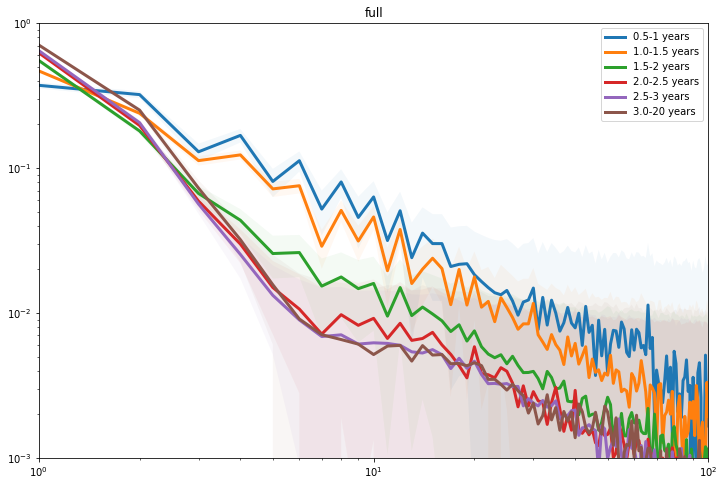

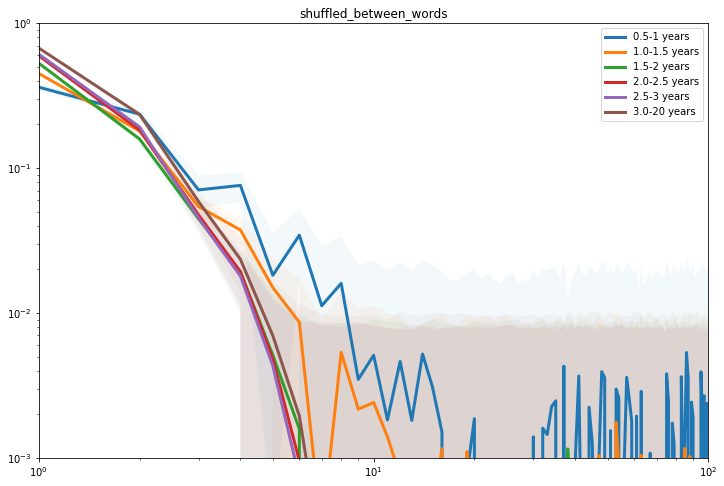

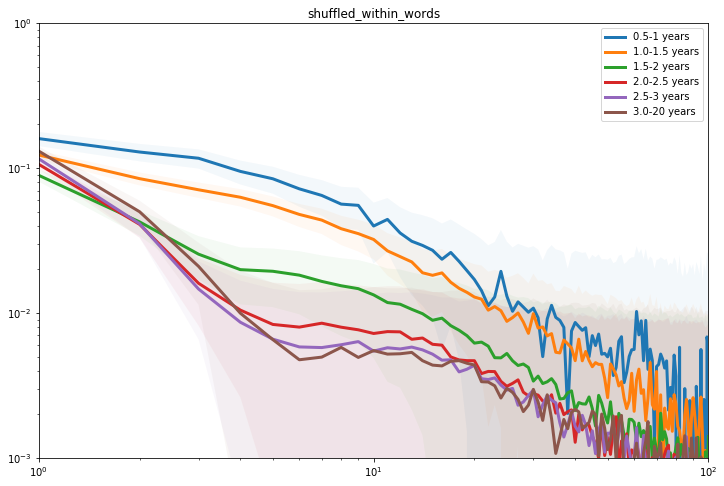

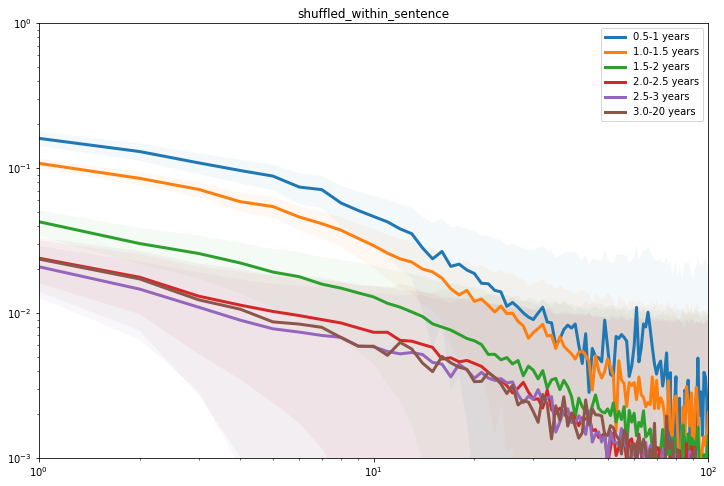

In [29]:
for shuff in ['full', 'shuffled_between_words', 'shuffled_within_words', 'shuffled_within_sentence']:
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.set_title(shuff)
    for idx, row in mi_df.iterrows():
        if row.shuffling != shuff: 
            continue
        MI = row.MI-row.shuff_MI
        MI_var = row.MI_var
        #ax.scatter(distances, row.MI-row.shuff_MI)
        ax.plot(distances, row.MI-row.shuff_MI, label = '{}-{} years'.format(row.age_cohort_low, row.age_cohort_high), lw=3)
        ax.fill_between(distances, MI-MI_var, MI+MI_var, alpha = 0.05)

    ax.legend()
    ax.set_ylim([1e-3,1])
    ax.set_xlim([1, 100])

    ax.set_yscale('log')
    ax.set_xscale('log')
    plt.show()

full


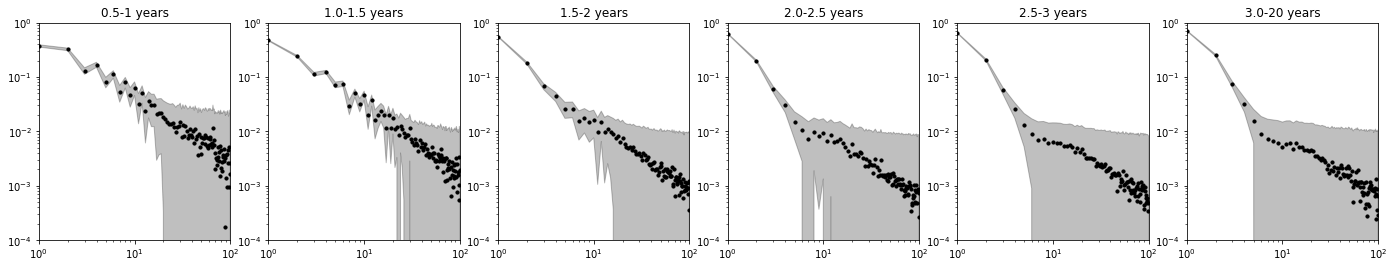

shuffled_between_words


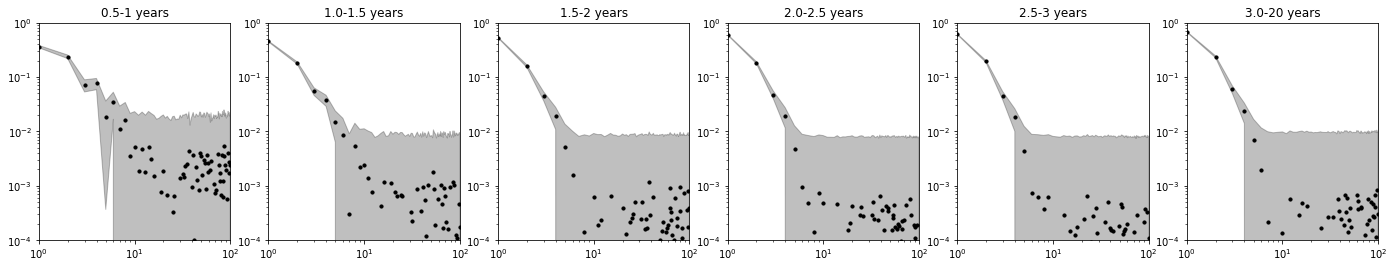

shuffled_within_words


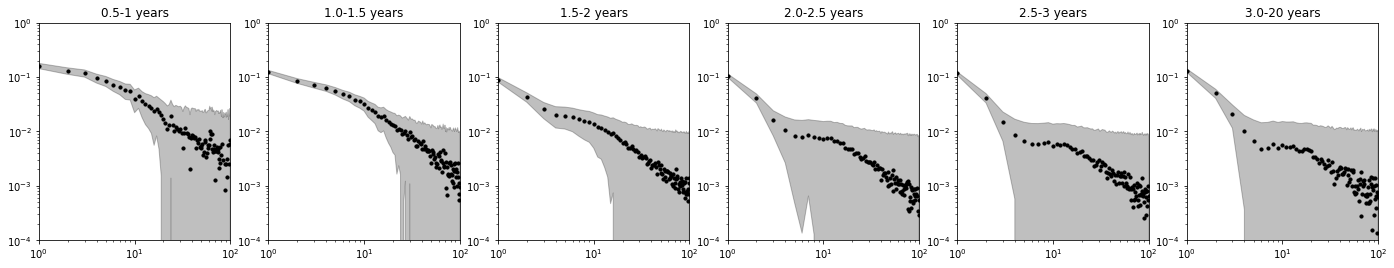

shuffled_within_sentence


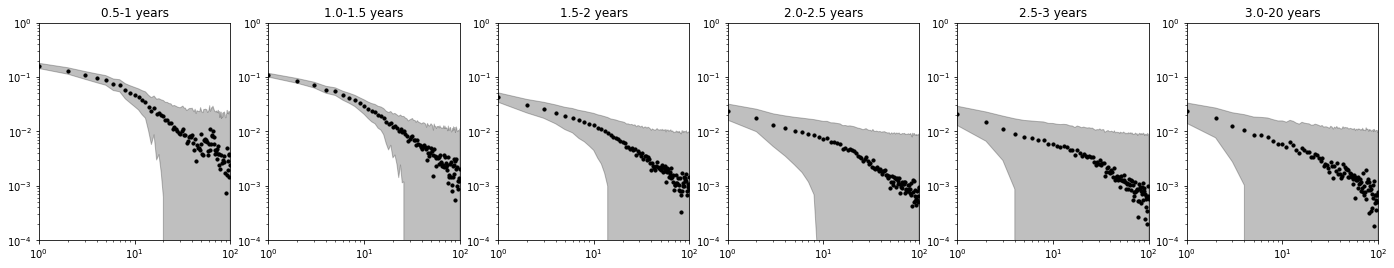

no_repeats


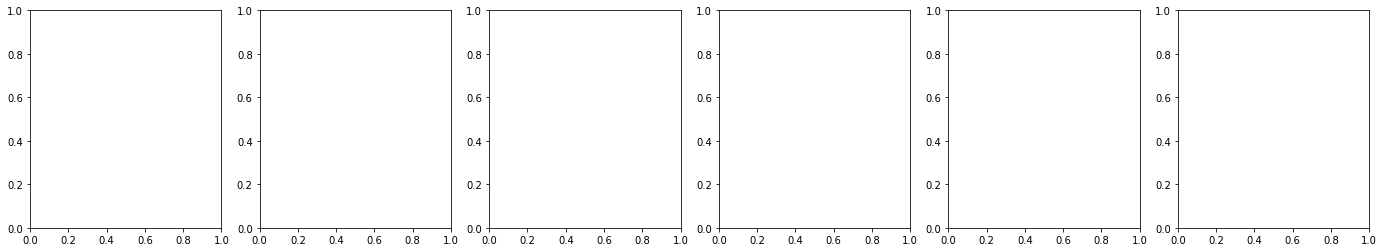

In [31]:
for shuff in ['full', 'shuffled_between_words', 'shuffled_within_words', 'shuffled_within_sentence', 'no_repeats']:
    print(shuff)
    fig, axs = plt.subplots(ncols=len(age_cohorts), figsize=(4*len(age_cohorts),4))

    for axi, (idx, row) in enumerate(mi_df.iterrows()):
        if row.shuffling != shuff: 
            continue
        MI = row.MI-row.shuff_MI
        MI_var = row.MI_var
        #ax.scatter(distances, row.MI-row.shuff_MI)
        ax = axs[np.array([i[0] for i in age_cohorts]) == row.age_cohort_low][0]
        #ax.plot(distances, row.MI-row.shuff_MI, label = '{}-{} years'.format(row.age_cohort_low, row.age_cohort_high), lw=3)
        ax.scatter(distances, row.MI-row.shuff_MI, s=10, color='k')
        ax.fill_between(distances, MI-MI_var, MI+MI_var, alpha = 0.25, color= 'k')
        #ax.legend()
        ax.set_title('{}-{} years'.format(row.age_cohort_low, row.age_cohort_high))
        ax.set_ylim([1e-4,1])
        ax.set_xlim([1, 100])

        ax.set_yscale('log')
        ax.set_xscale('log')
    plt.show()